# Main Noteboook
this is the core notebook that soon to be implemented in src/

In [17]:
# CORE
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle
import joblib

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# SCIKIT-LEARN PREPROCESSING
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize

# SCIKIT-LEARN MODEL SELECTION
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# SCIKIT-LEARN METRICS
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.metrics.pairwise import cosine_similarity

# IMBALANCED-LEARN 
from imblearn.over_sampling import SMOTE

# MACHINE LEARNING MODELS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# TENSORFLOW / KERAS
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Data Preprocessing
Pada data preprocessing ini tidak ada handling untuk missing values dan duplicates karena dataset yang disediakan tidak ada masalah tersebut

## Data Loading

In [2]:
# Load raw data
df = pd.read_csv('../data/raw/data_capstone.csv')
df.head()

,customer_id,plan_type,device_brand,avg_data_usage_gb,pct_video_usage,avg_call_duration,sms_freq,monthly_spend,topup_freq,travel_score,complaint_count,target_offer
0,C00001,Prepaid,Realme,1.50,0.804146,7.98,13,70000.0,4,0.284419,0,General Offer
1,C00002,Postpaid,Vivo,1.09,0.107686,9.56,9,63000.0,3,0.115086,0,General Offer
2,C00003,Postpaid,Xiaomi,3.24,0.313894,4.61,13,89000.0,7,0.402998,0,General Offer
3,C00004,Prepaid,Apple,5.32,0.420158,6.96,8,67000.0,4,0.302169,0,General Offer
4,C00005,Prepaid,Huawei,1.91,0.251638,11.01,21,72000.0,5,0.487911,0,General Offer


## Outlier Handling

### Visualize

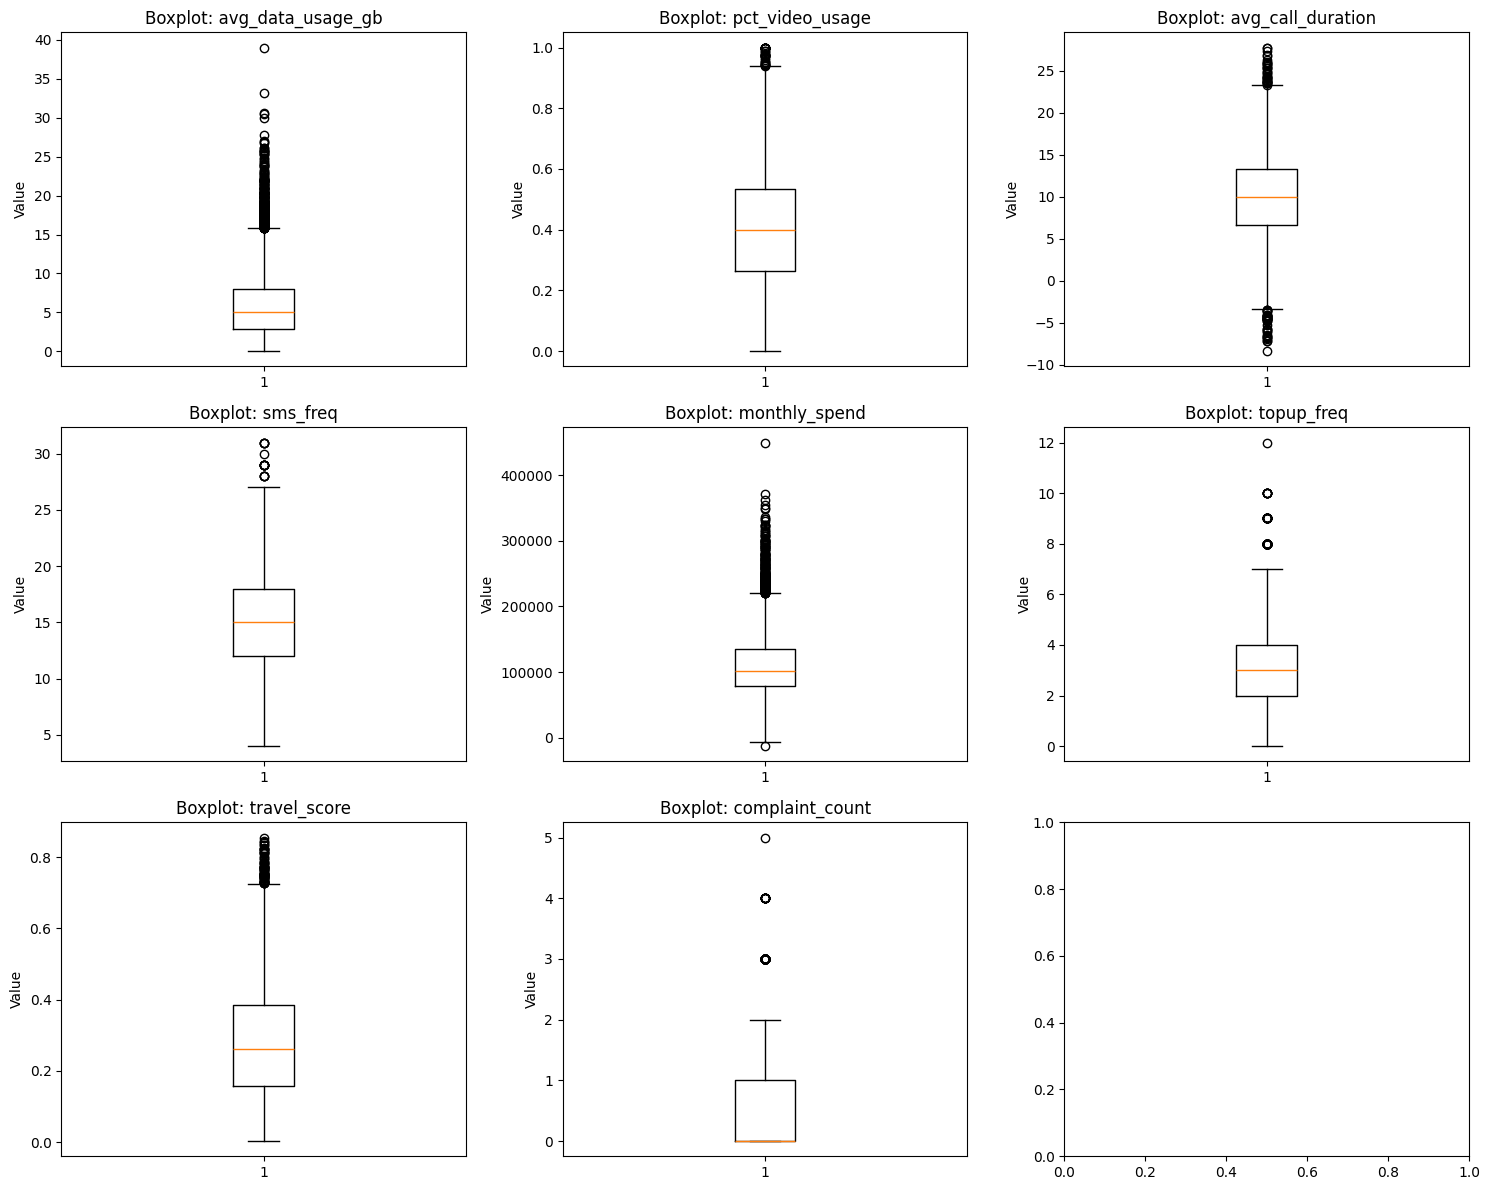

In [3]:
# Deteksi Outliers dengan IQR
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Visualisasi Outliers dengan Boxplot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        axes[idx].boxplot(df[col].dropna())
        axes[idx].set_title(f'Boxplot: {col}')
        axes[idx].set_ylabel('Value')

plt.tight_layout()
plt.show()

### Detecting

In [4]:
# Hapus kolom yang bukan fitur (seperti customer_id sudah object, jadi aman)
# Tapi hapus kolom target atau ID jika ada dalam numerical
print("DETEKSI OUTLIERS (IQR METHOD)")

outlier_info = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_info[col] = len(outliers)
    
    print(f"\n{col}:")
    print(f"  Lower bound: {lower_bound:.2f}")
    print(f"  Upper bound: {upper_bound:.2f}")
    print(f"  Jumlah outliers: {len(outliers)}")

DETEKSI OUTLIERS (IQR METHOD)

avg_data_usage_gb:
  Lower bound: -4.88
  Upper bound: 15.79
  Jumlah outliers: 305

pct_video_usage:
  Lower bound: -0.14
  Upper bound: 0.94
  Jumlah outliers: 40

avg_call_duration:
  Lower bound: -3.35
  Upper bound: 23.32
  Jumlah outliers: 72

sms_freq:
  Lower bound: 3.00
  Upper bound: 27.00
  Jumlah outliers: 17

monthly_spend:
  Lower bound: -7500.00
  Upper bound: 220500.00
  Jumlah outliers: 250

topup_freq:
  Lower bound: -1.00
  Upper bound: 7.00
  Jumlah outliers: 110

travel_score:
  Lower bound: -0.18
  Upper bound: 0.73
  Jumlah outliers: 70

complaint_count:
  Lower bound: -1.50
  Upper bound: 2.50
  Jumlah outliers: 138


### Summary

In [5]:
print("\nSUMMARY OUTLIERS")
for col, count in outlier_info.items():
    if count > 0:
        print(f"{col}: {count} outliers ({count/len(df)*100:.2f}%)")


SUMMARY OUTLIERS
avg_data_usage_gb: 305 outliers (3.05%)
pct_video_usage: 40 outliers (0.40%)
avg_call_duration: 72 outliers (0.72%)
sms_freq: 17 outliers (0.17%)
monthly_spend: 250 outliers (2.50%)
topup_freq: 110 outliers (1.10%)
travel_score: 70 outliers (0.70%)
complaint_count: 138 outliers (1.38%)


### Remove the outlier

In [6]:
# Strategy: Remove rows where any numeric column has outliers (based on IQR)
# Create a mask for rows to keep (no outliers in any numeric column)
mask = pd.Series([True] * len(df))
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)

df_before_outlier_handling = df.copy()
df = df[mask].copy()

print(f"Rows before outlier handling: {len(df_before_outlier_handling)}")
print(f"Rows after outlier handling: {len(df)}")
print(f"Rows removed: {len(df_before_outlier_handling) - len(df)}")

Rows before outlier handling: 10000
Rows after outlier handling: 9231
Rows removed: 769


### Visualization the Before and After removing the outlier

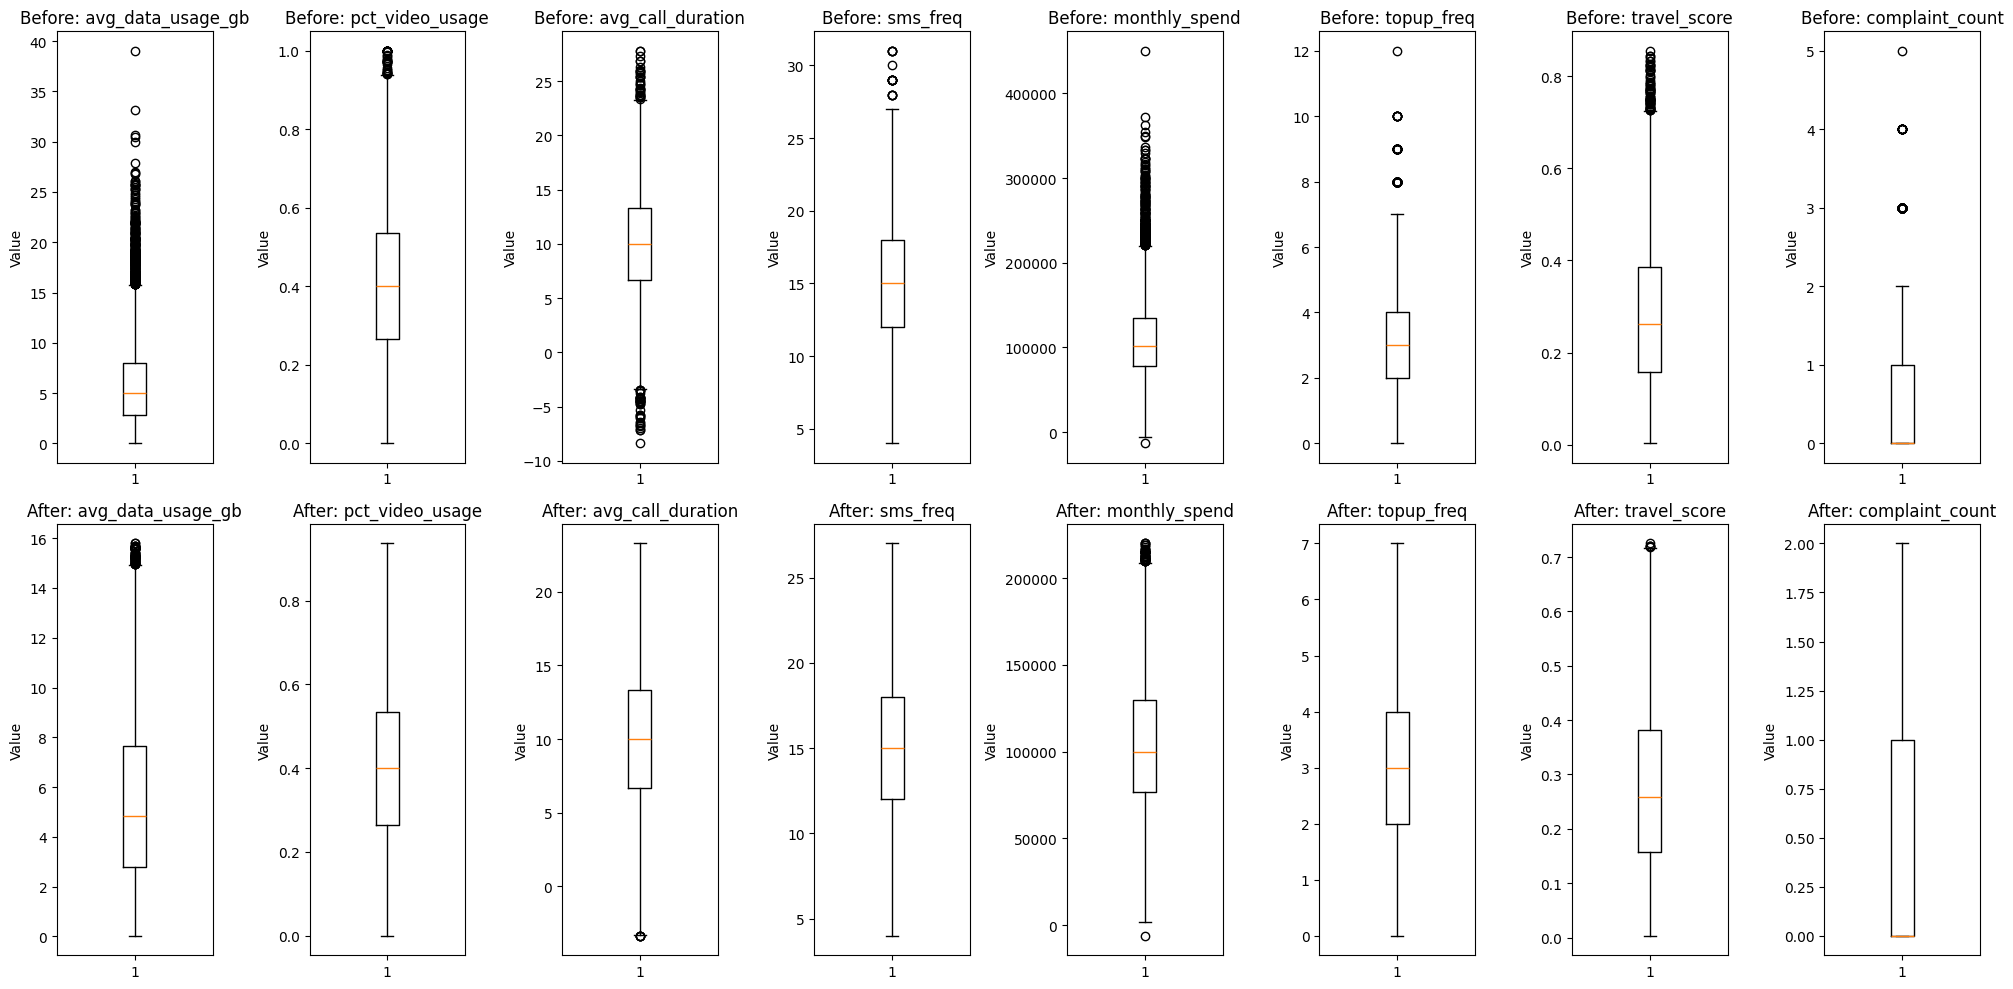

In [7]:

# Visualize Before and After Outlier Handling
fig, axes = plt.subplots(2, len(numerical_cols), figsize=(20, 10))

for idx, col in enumerate(numerical_cols):
    # Before
    axes[0, idx].boxplot(df_before_outlier_handling[col].dropna())
    axes[0, idx].set_title(f'Before: {col}')
    axes[0, idx].set_ylabel('Value')
    
    # After
    axes[1, idx].boxplot(df[col].dropna())
    axes[1, idx].set_title(f'After: {col}')
    axes[1, idx].set_ylabel('Value')

plt.tight_layout()
plt.show()

### Remove Negative Values

In [8]:
# Remove negative numeric values (drop rows where any numeric column < 0)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
neg_counts = (df[num_cols] < 0).sum()
print("Negative value counts per numeric column:")
print(neg_counts[neg_counts > 0])

# Hitung berapa baris yang memiliki nilai negatif di kolom numerik apapun
rows_with_neg = df[(df[num_cols] < 0).any(axis=1)].shape[0]
print(f"\nTotal baris dengan setidaknya satu nilai numeric negatif: {rows_with_neg}")

if rows_with_neg > 0:
    df_before = len(df)
    # Drop rows that have any negative numeric value
    df = df[~(df[num_cols] < 0).any(axis=1)].copy()
    df_after = len(df)
    print(f"Baris sebelum: {df_before}; baris sesudah: {df_after}; terhapus: {df_before - df_after}")
else:
    print("Tidak ditemukan nilai numeric negatif — tidak ada perubahan pada dataframe")


Negative value counts per numeric column:
avg_call_duration    180
monthly_spend          1
dtype: int64

Total baris dengan setidaknya satu nilai numeric negatif: 181
Baris sebelum: 9231; baris sesudah: 9050; terhapus: 181


## Feature Importance

THe reason for dropping sms_freq and avg_call_duration is connected to EDA where both of these feature actually useless compared to other, here is the output using decision tree with 6 depth:  
| Rank | Feature             | Importance |
|------|---------------------|------------|
| 1    | monthly_spend       | 0.274486   |
| 2    | complaint_count     | 0.177292   |
| 3    | device_brand        | 0.170882   |
| 4    | pct_video_usage     | 0.138131   |
| 5    | avg_data_usage_gb   | 0.130795   |
| 6    | plan_type           | 0.041409   |
| 7    | topup_freq          | 0.028904   |
| 8    | travel_score        | 0.027488   |
| 9    | avg_call_duration   | 0.007678   |
| 10   | sms_freq            | 0.002934   |


As you can see that the gap is huge between the third last and the second last, so we considering to drop them, and ofcourse excluding ID and target

In [9]:
# Drop fitur yang dikecualikan dari modeling

excluded_features = ['sms_freq', 'avg_call_duration']

df_before_drop = df.shape[1]
df = df.drop(columns=excluded_features, errors='ignore')
df_after_drop = df.shape[1]

print(f"\nJumlah kolom sebelum: {df_before_drop}")
print(f"Jumlah kolom sesudah: {df_after_drop}")
print(f"Kolom terhapus: {df_before_drop - df_after_drop}")
print(f"\nKolom yang tersisa:")
display(df.columns.tolist())


Jumlah kolom sebelum: 12
Jumlah kolom sesudah: 10
Kolom terhapus: 2

Kolom yang tersisa:


['customer_id',
 'plan_type',
 'device_brand',
 'avg_data_usage_gb',
 'pct_video_usage',
 'monthly_spend',
 'topup_freq',
 'travel_score',
 'complaint_count',
 'target_offer']

## Encoding

### Memisahkan feature & Target


In [10]:
# Simpan customer_id dan target sebelum encoding
customer_ids = df['customer_id'].copy()
target = df['target_offer'].copy()

# Drop kolom yang tidak perlu untuk modeling
df_encoded = df.drop(['customer_id', 'target_offer'], axis=1)

print("Kolom kategorikal yang akan di-encode:")
categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    print(f"  - {col}: {df_encoded[col].nunique()} unique values")

Kolom kategorikal yang akan di-encode:
  - plan_type: 2 unique values
  - device_brand: 7 unique values


### Label Encoding untuk target variable

In [11]:
le_target = LabelEncoder()
target_encoded = le_target.fit_transform(target)

print("\nTarget encoding:")
print(f"Classes: {le_target.classes_}")
print(f"Encoded values: {np.unique(target_encoded)}")

# Simpan mapping untuk interpretasi nanti
target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print(f"\nTarget mapping: {target_mapping}")


Target encoding:
Classes: ['Data Booster' 'Device Upgrade Offer' 'Family Plan Offer' 'General Offer'
 'Retention Offer' 'Roaming Pass' 'Streaming Partner Pack' 'Top-up Promo'
 'Voice Bundle']
Encoded values: [0 1 2 3 4 5 6 7 8]

Target mapping: {'Data Booster': np.int64(0), 'Device Upgrade Offer': np.int64(1), 'Family Plan Offer': np.int64(2), 'General Offer': np.int64(3), 'Retention Offer': np.int64(4), 'Roaming Pass': np.int64(5), 'Streaming Partner Pack': np.int64(6), 'Top-up Promo': np.int64(7), 'Voice Bundle': np.int64(8)}


### Encoding Process

In [12]:
# One-Hot Encoding untuk features kategorikal
# Untuk kolom dengan cardinalitas rendah gunakan One-Hot
# Untuk kolom dengan cardinalitas tinggi gunakan Label Encoding atau Target Encoding

df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

print(f"Shape setelah encoding: {df_encoded.shape}")
print(f"Total features setelah encoding: {df_encoded.shape[1]}")

Shape setelah encoding: (9050, 13)
Total features setelah encoding: 13


## Normalization (Scalling)

In [13]:
# Initialize scaler
scaler = StandardScaler()

# Fit dan transform pada features
X_scaled = scaler.fit_transform(df_encoded)

# Convert kembali ke DataFrame untuk kemudahan
df_scaled = pd.DataFrame(X_scaled, columns=df_encoded.columns, index=df_encoded.index)

print(f"Shape data setelah scaling: {df_scaled.shape}")
print("\nStatistik setelah scaling (sampel 5 kolom pertama):")
print(df_scaled.iloc[:, :5].describe())

Shape data setelah scaling: (9050, 13)

Statistik setelah scaling (sampel 5 kolom pertama):
       avg_data_usage_gb  pct_video_usage  monthly_spend    topup_freq  \
count       9.050000e+03     9.050000e+03   9.050000e+03  9.050000e+03   
mean        6.398810e-17     1.491747e-16  -2.983494e-17 -1.177695e-18   
std         1.000055e+00     1.000055e+00   1.000055e+00  1.000055e+00   
min        -1.593304e+00    -2.079872e+00  -2.642914e+00 -1.807362e+00   
25%        -7.873107e-01    -7.011453e-01  -7.220765e-01 -5.707532e-01   
50%        -1.966369e-01    -4.083841e-03  -1.330196e-01  4.755138e-02   
75%         6.268149e-01     6.956481e-01   6.353155e-01  6.658560e-01   
max         2.992420e+00     2.777966e+00   2.940321e+00  2.520770e+00   

       travel_score  
count  9.050000e+03  
mean  -1.978528e-16  
std    1.000055e+00  
min   -1.795757e+00  
25%   -7.862936e-01  
50%   -1.246112e-01  
75%    6.764668e-01  
max    2.923785e+00  


## Data Split

### Split 80/20

In [14]:
# Split dengan stratified untuk menjaga proporsi target
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled, 
    target_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=target_encoded
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nProporsi split:")
print(f"  Training: {len(X_train)/len(df_scaled)*100:.1f}%")
print(f"  Testing: {len(X_test)/len(df_scaled)*100:.1f}%")

# Cek distribusi target di train dan test
print(f"\nDistribusi target di training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_train)*100:.1f}%)")

print(f"\nDistribusi target di testing set:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_test)*100:.1f}%)")

X_train shape: (7240, 13)
X_test shape: (1810, 13)
y_train shape: (7240,)
y_test shape: (1810,)

Proporsi split:
  Training: 80.0%
  Testing: 20.0%

Distribusi target di training set:
  Class 0: 521 (7.2%)
  Class 1: 1035 (14.3%)
  Class 2: 57 (0.8%)
  Class 3: 4587 (63.4%)
  Class 4: 507 (7.0%)
  Class 5: 23 (0.3%)
  Class 6: 196 (2.7%)
  Class 7: 275 (3.8%)
  Class 8: 39 (0.5%)

Distribusi target di testing set:
  Class 0: 130 (7.2%)
  Class 1: 259 (14.3%)
  Class 2: 14 (0.8%)
  Class 3: 1147 (63.4%)
  Class 4: 127 (7.0%)
  Class 5: 6 (0.3%)
  Class 6: 49 (2.7%)
  Class 7: 69 (3.8%)
  Class 8: 9 (0.5%)


### Handle Imbalanced Data dengan SMOTE 
**PENTING:** Data memiliki imbalance ratio 89:1 (General Offer vs Voice Bundle)  
SMOTE akan membuat synthetic samples untuk kelas minoritas agar model tidak bias

In [15]:
# Cek distribusi sebelum SMOTE
print("\n DISTRIBUSI SEBELUM SMOTE:")
print("Training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    class_name = le_target.classes_[u]
    print(f"  {class_name}: {c:,} ({c/len(y_train)*100:.1f}%)")

print(f"\nTotal training samples: {len(y_train):,}")


 DISTRIBUSI SEBELUM SMOTE:
Training set:
  Data Booster: 521 (7.2%)
  Device Upgrade Offer: 1,035 (14.3%)
  Family Plan Offer: 57 (0.8%)
  General Offer: 4,587 (63.4%)
  Retention Offer: 507 (7.0%)
  Roaming Pass: 23 (0.3%)
  Streaming Partner Pack: 196 (2.7%)
  Top-up Promo: 275 (3.8%)
  Voice Bundle: 39 (0.5%)

Total training samples: 7,240


In [18]:
# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Cek distribusi setelah SMOTE
print("\n DISTRIBUSI SETELAH SMOTE:")
print("Training set (balanced):")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for u, c in zip(unique, counts):
    class_name = le_target.classes_[u]
    print(f"  {class_name}: {c:,} ({c/len(y_train_balanced)*100:.1f}%)")

print(f"\nTotal training samples setelah SMOTE: {len(y_train_balanced):,}")
print(f"Penambahan data: {len(y_train_balanced) - len(y_train):,} samples")
print(f"\n Test set TIDAK diubah (tetap {len(y_test):,} samples)")



 DISTRIBUSI SETELAH SMOTE:
Training set (balanced):
  Data Booster: 4,587 (11.1%)
  Device Upgrade Offer: 4,587 (11.1%)
  Family Plan Offer: 4,587 (11.1%)
  General Offer: 4,587 (11.1%)
  Retention Offer: 4,587 (11.1%)
  Roaming Pass: 4,587 (11.1%)
  Streaming Partner Pack: 4,587 (11.1%)
  Top-up Promo: 4,587 (11.1%)
  Voice Bundle: 4,587 (11.1%)

Total training samples setelah SMOTE: 41,283
Penambahan data: 34,043 samples

 Test set TIDAK diubah (tetap 1,810 samples)


### Visualization comparison

✓ Visualisasi disimpan ke: ../data/plot/smote_comparison.png


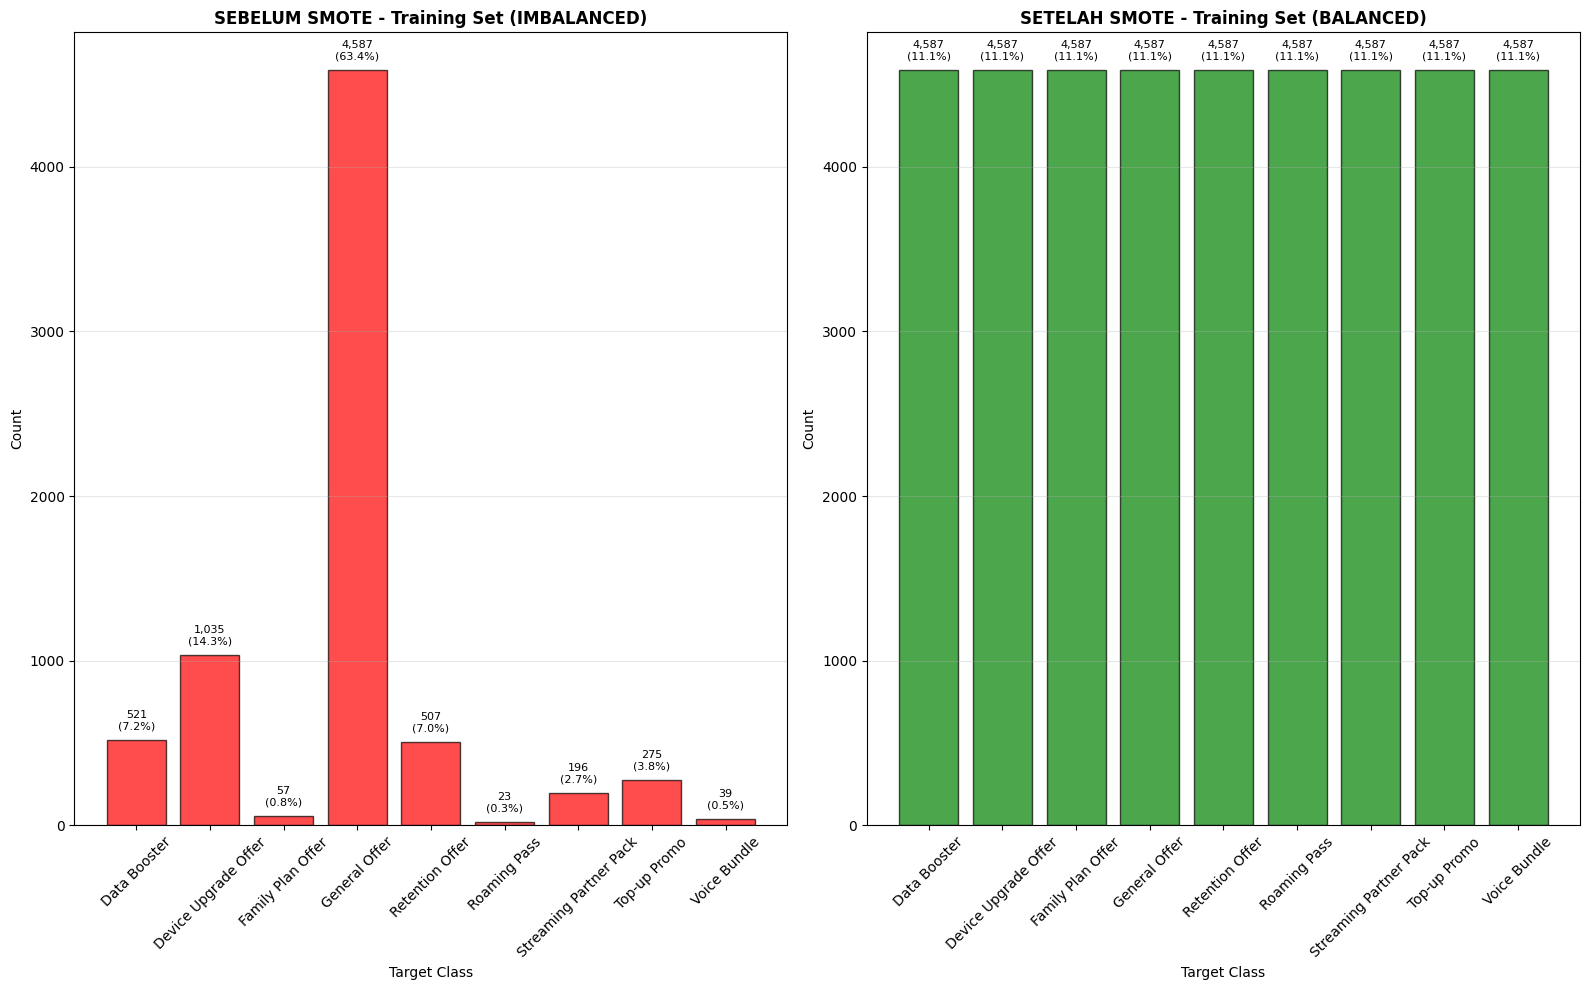

In [21]:
# Visualisasi distribusi sebelum dan sesudah SMOTE
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Before SMOTE
unique_before, counts_before = np.unique(y_train, return_counts=True)
class_names = [le_target.classes_[u] for u in unique_before]
axes[0].bar(class_names, counts_before, edgecolor='black', alpha=0.7, color='red')
axes[0].set_title('SEBELUM SMOTE - Training Set (IMBALANCED)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Target Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(counts_before):
    axes[0].text(i, v + 50, f'{v:,}\n({v/len(y_train)*100:.1f}%)', ha='center', va='bottom', fontsize=8)

# After SMOTE
unique_after, counts_after = np.unique(y_train_balanced, return_counts=True)
class_names = [le_target.classes_[u] for u in unique_after]
axes[1].bar(class_names, counts_after, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('SETELAH SMOTE - Training Set (BALANCED)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Target Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(counts_after):
    axes[1].text(i, v + 50, f'{v:,}\n({v/len(y_train_balanced)*100:.1f}%)', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../data/plot/smote_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualisasi disimpan ke: ../data/plot/smote_comparison.png")
plt.show()

## Save the processed data

In [22]:
# Save train-test split (MENGGUNAKAN DATA YANG SUDAH DI-SMOTE)
print("\n Saving balanced training data (after SMOTE)...")
np.save('../data/processed/X_train.npy', X_train_balanced)
np.save('../data/processed/y_train.npy', y_train_balanced)

print(" Saving original test data...")
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_test.npy', y_test)

# Save scaler dan encoder untuk production use
with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('../data/processed/label_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)

# Save feature names
with open('../data/processed/feature_names.pkl', 'wb') as f:
    pickle.dump(df_scaled.columns.tolist(), f)

# Save target mapping
with open('../data/processed/target_mapping.pkl', 'wb') as f:
    pickle.dump(target_mapping, f)

# Save processed dataframe lengkap (optional)
df_final = df_scaled.copy()
df_final['target'] = target_encoded
df_final.to_csv('../data/processed/processed_data.csv', index=False)
print(f"\n Training set size: {len(y_train_balanced):,} (setelah SMOTE)")
print(f" Test set size: {len(y_test):,} (data original)")


 Saving balanced training data (after SMOTE)...
 Saving original test data...

 Training set size: 41,283 (setelah SMOTE)
 Test set size: 1,810 (data original)
